In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Selise/

/content/drive/MyDrive/Selise


In [ ]:
ls

dataset_256X256/            res18_res50_ensmeble/
dataset_256X256.zip         resnet018/
__MACOSX/                   resnet050/
Problem_2_ensembling.ipynb  resnet18/
Problem_2_resnet18.ipynb    Sameer_Aqib_Hashmi_DS_Assessment.ipynb


In [ ]:
# !unzip /content/drive/MyDrive/Selise/dataset_256X256.zip

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import KFold
import numpy as np
from collections import defaultdict

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from tqdm import tqdm

In [ ]:
# Calculate Accuracy

def calculate_accuracy(output, target):
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images)
        preds = torch.argmax(output, dim=1)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(preds, target)

        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg']

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            preds = torch.argmax(output, dim=1)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(preds, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
          
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg']

In [ ]:
def model_save(epoch, model, optimizer, PATH):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, PATH)

In [ ]:
path_training_folder= "/content/drive/MyDrive/Selise/dataset_256X256/train"

In [ ]:
transform = transforms.Compose(
        [transforms.CenterCrop(255),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root=path_training_folder,transform=transform)

### Resnet18 model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch: 1. Train.      Loss: 0.321 | Accuracy: 0.884: 100%|██████████| 60/60 [04:40<00:00,  4.68s/it]
Epoch: 1. Validation. Loss: 0.217 | Accuracy: 0.912: 100%|██████████| 15/15 [01:19<00:00,  5.27s/it]
Epoch: 2. Train.      Loss: 0.160 | Accuracy: 0.941: 100%|██████████| 60/60 [00:21<00:00,  2.83it/s]
Epoch: 2. Validation. Loss: 1.073 | Accuracy: 0.732: 100%|██████████| 15/15 

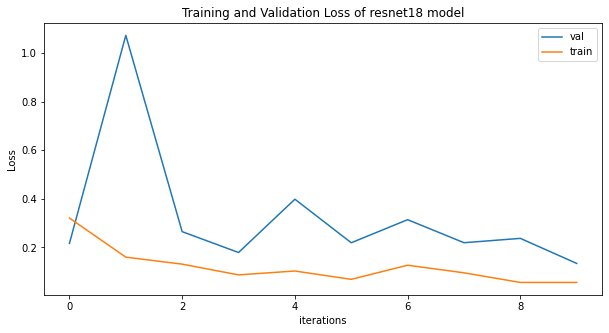

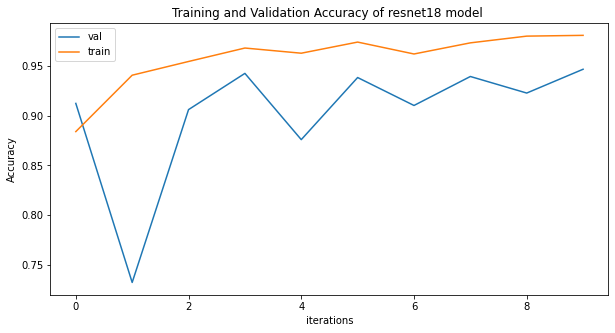

In [ ]:
params = {
    "model": "resnet18",
    "feature_dimension": 512,
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 2,
    "epochs": 10,
}

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset)):    
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
        
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'],
                                                shuffle=False, num_workers=params['num_workers'], sampler=train_sampler)
        
    testloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'],
                                                shuffle=False, num_workers=params['num_workers'], sampler=valid_sampler)


class CustomModel(nn.Module):
    def __init__(self, model_name=params["model"], feature_dim=params["feature_dimension"], class_number=4):
        super(CustomModel, self).__init__()
        self.model_name = model_name
        self.feature_dim = feature_dim
        self.class_number = class_number
        self.ready_model = self.model_return()

    def model_return(self):
        pre_model = getattr(models, self.model_name)(pretrained=True)
        # print(pre_model)
        pre_model.fc = nn.Identity()
        pre_model.fc = nn.Linear(in_features=self.feature_dim, out_features=self.class_number, bias=True)
        return pre_model

    def forward(self, x):
        output = self.ready_model(x)
        return output   

resnet18_model = CustomModel()

model = resnet18_model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    
train_losses = []
train_acc = []

val_losses = []
val_acc = []

prev_accuracy = 0
for epoch in range(1, params["epochs"] + 1):
    train_loss, train_accuracy = train(trainloader, model, criterion, optimizer, epoch, params)
    val_loss, val_accuracy = validate(testloader, model, criterion, epoch, params)
    if val_accuracy > prev_accuracy:
        model_save(epoch, model, optimizer, PATH = f"/content/drive/MyDrive/Selise/resnet018/my_model_epoch_{epoch}.pth")
        prev_accuracy = val_accuracy
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

############ loss curve ############
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss of resnet18 model")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

############ accuracy curve ############
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy of resnet18 model ")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### inference pipeline for resnet18 model

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.2 MB/s 


In [ ]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import MulticlassConfusionMatrix

test_data_folder = "/content/drive/MyDrive/Selise/dataset_256X256/test"

transform = transforms.Compose(
        [transforms.CenterCrop(255),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_dataset = torchvision.datasets.ImageFolder(root=test_data_folder,transform=transform)

inference_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

### Calculating matrics

def calculate_metrics(output, target):
    target = target.cpu()
    output = output.cpu()
    
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item() #, f1_score(target, output, average='micro'), precision_score(target, output, average='micro')

def test(test_loader, model, criterion, epoch, params, print_confusion=False):
    y_pred = []
    y_target = []
    metric_monitor = MetricMonitor()
    path = "/content/drive/MyDrive/Selise/resnet018/my_model_epoch_10.pth"
    checkpoint = torch.load(path, map_location=params['device'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    model.eval()
    stream = tqdm(test_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            preds = torch.argmax(output, dim=1)

            
            accuracy = calculate_metrics(preds, target)
            
            
            metric_monitor.update("Accuracy", accuracy)
            # metric_monitor.update("F1-Score", f1_score_var)
            # metric_monitor.update("Precision-", precision)
            stream.set_description(
                "Epoch: {epoch}. Test. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
            y_pred.append(preds.tolist())
            y_target.append(target.tolist())

        
        
    return accuracy, y_pred, y_target





In [ ]:
test_accuracy, preds, targets = test(inference_dataloader, model, criterion, epoch, params)

Epoch: 10. Test. Accuracy: 0.953: 100%|██████████| 25/25 [04:29<00:00, 10.79s/it]


[[393   4   1   2]
 [  6 373  19   2]
 [  2   6 392   0]
 [ 32   2   0 366]]


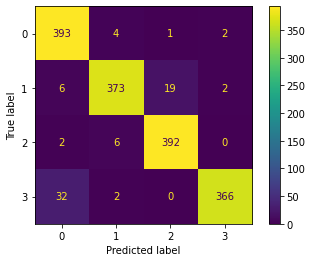

In [ ]:
cm = confusion_matrix(np.array(targets).flatten(), np.array(preds).flatten())
print(cm)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

My train and val accuracy was not that much different. Even train and val loss didn't have much difference. Also my test accuracy is very good as you can see in confusion matrix. So, I can say my model is not overfitted.

### Resnet50 model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch: 1. Train.      Loss: 0.522 | Accuracy: 0.818: 100%|██████████| 60/60 [00:49<00:00,  1.20it/s]
Epoch: 1. Validation. Loss: 0.970 | Accuracy: 0.745: 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]
Epoch: 2. Train.      Loss: 0.307 | Accuracy: 0.892: 100%|██████████| 60/60 [00:49<00:00,  1.22it/s]
Epoch: 2. Validation. Loss: 1.018 | Accuracy: 0.721: 100%|██████████| 15/15 [00:04<00:00,  3.02it/s]
Epoch: 3. Train.      Loss: 0.259 | Accuracy: 0.907: 100%|██████████| 60/60 [00:49<00:00,  1.22it/s]
Epoch: 3. Validation. Loss: 0.251 | Accuracy: 0.912: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]
Epoch: 4. Train.      Loss: 0.166 | Accuracy: 0.943: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]
Epoch: 4. Validation. Loss: 0.562 | Accuracy: 0.836: 100%|██████████| 15/15 [00:04<00:00,  3.08it/s]
Epoch: 5. Train.      Loss: 0.153 | Accuracy: 0.944: 100%|██████████| 60/60 [00:49<00:00,  1.22it/s]
Epoch: 5. Validation. Loss: 0.305 | Accuracy: 0.903: 100%|██████████| 15/15 [00:04<00:00,  

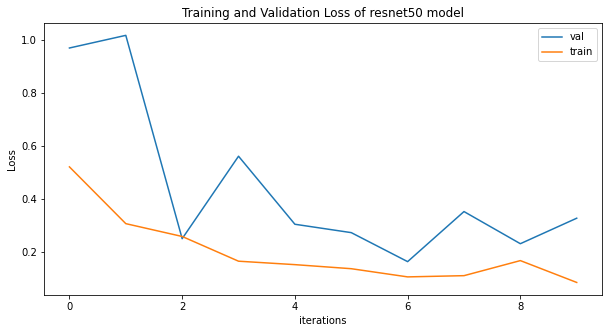

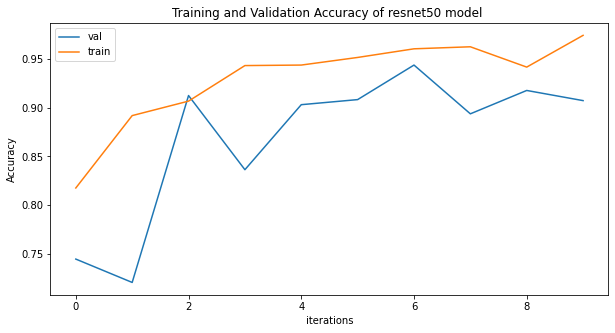

In [ ]:
params = {
    "model": "resnet50",
    "feature_dimension": 2048,
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 2,
    "epochs": 10,
}

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset)):    
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
        
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'],
                                                shuffle=False, num_workers=params['num_workers'], sampler=train_sampler)
        
    testloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'],
                                                shuffle=False, num_workers=params['num_workers'], sampler=valid_sampler)


class CustomModel(nn.Module):
    def __init__(self, model_name=params["model"], feature_dim=params["feature_dimension"], class_number=4):
        super(CustomModel, self).__init__()
        self.model_name = model_name
        self.feature_dim = feature_dim
        self.class_number = class_number
        self.ready_model = self.model_return()

    def model_return(self):
        pre_model = getattr(models, self.model_name)(pretrained=True)
        # print(pre_model)
        pre_model.fc = nn.Identity()
        pre_model.fc = nn.Linear(in_features=self.feature_dim, out_features=self.class_number, bias=True)
        return pre_model

    def forward(self, x):
        output = self.ready_model(x)
        return output   

resnet50_model = CustomModel()

model = resnet50_model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    
train_losses = []
train_acc = []

val_losses = []
val_acc = []

prev_accuracy = 0
for epoch in range(1, params["epochs"] + 1):
    train_loss, train_accuracy = train(trainloader, model, criterion, optimizer, epoch, params)
    val_loss, val_accuracy = validate(testloader, model, criterion, epoch, params)
    if val_accuracy > prev_accuracy:
        model_save(epoch, model, optimizer, PATH = f"/content/drive/MyDrive/Selise/resnet050/my_model_epoch_{epoch}.pth")
        prev_accuracy = val_accuracy
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

############ loss curve ############
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss of resnet50 model")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

############ accuracy curve ############
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy of resnet50 model ")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Ensembling

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super().__init__()
        self.model1param = nn.parameter.Parameter(data= torch.tensor(0.4) ,requires_grad=True)
        self.model2param = nn.parameter.Parameter(data= torch.tensor(0.6) ,requires_grad=True)
        self.res18 = model1
        self.res18.load_state_dict(torch.load('/content/drive/MyDrive/Selise/resnet018/my_model_epoch_10.pth')['model_state_dict'])

        for param in self.res18.parameters():
            param.requires_grad = False
        
        self.res50 = model2
        self.res50.load_state_dict(torch.load('/content/drive/MyDrive/Selise/resnet050/my_model_epoch_7.pth')['model_state_dict'])

        for param in self.res50.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.res18(x)*self.model1param + self.res50(x)*self.model2param

In [ ]:
ensemble_model = EnsembleModel(resnet18_model, resnet50_model)

Epoch: 1. Train.      Loss: 0.027 | Accuracy: 0.994: 100%|██████████| 60/60 [00:23<00:00,  2.53it/s]
Epoch: 1. Validation. Loss: 0.036 | Accuracy: 0.991: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]
Epoch: 2. Train.      Loss: 0.026 | Accuracy: 0.992: 100%|██████████| 60/60 [00:23<00:00,  2.51it/s]
Epoch: 2. Validation. Loss: 0.036 | Accuracy: 0.989: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]
Epoch: 3. Train.      Loss: 0.031 | Accuracy: 0.990: 100%|██████████| 60/60 [00:23<00:00,  2.59it/s]
Epoch: 3. Validation. Loss: 0.028 | Accuracy: 0.991: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]
Epoch: 4. Train.      Loss: 0.022 | Accuracy: 0.993: 100%|██████████| 60/60 [00:23<00:00,  2.58it/s]
Epoch: 4. Validation. Loss: 0.032 | Accuracy: 0.993: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]
Epoch: 5. Train.      Loss: 0.022 | Accuracy: 0.995: 100%|██████████| 60/60 [00:23<00:00,  2.50it/s]
Epoch: 5. Validation. Loss: 0.034 | Accuracy: 0.988: 100%|██████████| 15/15 [00:05<00:00,  

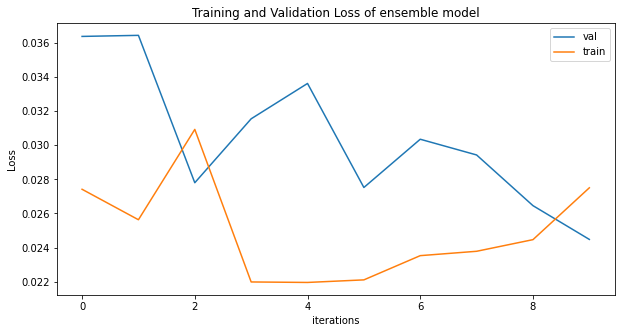

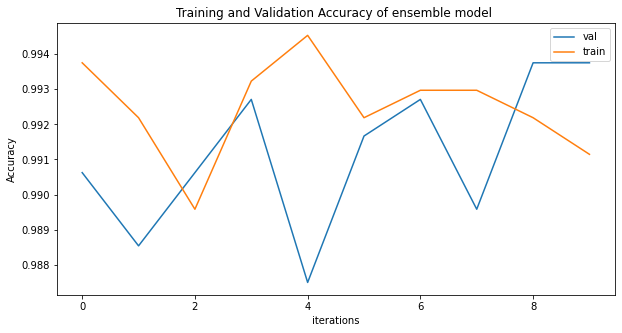

In [ ]:
model = ensemble_model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    
train_losses = []
train_acc = []

val_losses = []
val_acc = []

prev_accuracy = 0
for epoch in range(1, params["epochs"] + 1):
    train_loss, train_accuracy = train(trainloader, model, criterion, optimizer, epoch, params)
    val_loss, val_accuracy = validate(testloader, model, criterion, epoch, params)
    if val_accuracy > prev_accuracy:
        model_save(epoch, model, optimizer, PATH = f"/content/drive/MyDrive/Selise/res18_res50_ensmeble/my_model_epoch_{epoch}.pth")
        prev_accuracy = val_accuracy
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

############ loss curve ############
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss of ensemble model")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

############ accuracy curve ############
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy of ensemble model ")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Inference Pipeline

In [ ]:
from sklearn.metrics import f1_score, precision_score

test_data_folder = "/content/drive/MyDrive/Selise/dataset_256X256/test"

transform = transforms.Compose(
        [transforms.CenterCrop(255),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_dataset = torchvision.datasets.ImageFolder(root=test_data_folder,transform=transform)

inference_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

### Calculating matrics

def calculate_metrics(output, target):
    target = target.cpu()
    output = output.cpu()
    
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item() #, f1_score(target, output, average='micro'), precision_score(target, output, average='micro')

def test(test_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    path = "/content/drive/MyDrive/Selise/res18_res50_ensmeble/my_model_epoch_1.pth"
    checkpoint = torch.load(path, map_location=params['device'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    model.eval()
    stream = tqdm(test_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            preds = torch.argmax(output, dim=1)
            
            accuracy = calculate_metrics(preds, target)
            
            metric_monitor.update("Accuracy", accuracy)
            # metric_monitor.update("F1-Score", f1_score_var)
            # metric_monitor.update("Precision-", precision)
            stream.set_description(
                "Epoch: {epoch}. Test. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return accuracy

test_accuracy = test(inference_dataloader, model, criterion, epoch, params)


Epoch: 1. Test. Accuracy: 0.966: 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]


### image testing

In [ ]:
from PIL import Image

def classified_class(output):
    if output[0,0]>output[0,1] and output[0,0]>output[0,2] and output[0,0]>output[0,3]:
      return "Berry"
    elif output[0,1]>output[0,0] and output[0,1]>output[0,2] and output[0,1]>output[0,3]:
      return "Bird"
    elif output[0,2]>output[0,0] and output[0,2]>output[0,1] and output[0,2]>output[0,3]:
      return "Dog"
    elif output[0,3]>output[0,0] and output[0,3]>output[0,1] and output[0,3]>output[0,2]:
      return "Flower"
    else:
      return "Unknown"

path = "/content/drive/MyDrive/Selise/res18_res50_ensmeble/my_model_epoch_1.pth"
checkpoint = torch.load(path, map_location=params['device'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

Dog


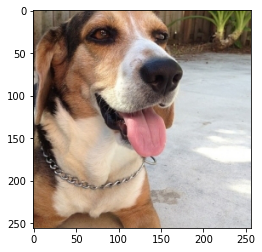

In [ ]:
image_for_inference = Image.open('/content/drive/MyDrive/Selise/dataset_256X256/test/dog/179_256.jpg')
# image_for_inference = image_for_inference.resize((32,32))
plt.imshow(image_for_inference)
image_for_inference = transform(image_for_inference)
model.eval()
output = model(image_for_inference.float().unsqueeze(0).to(params["device"], non_blocking=True))
predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
print(classified_class(output))

Berry


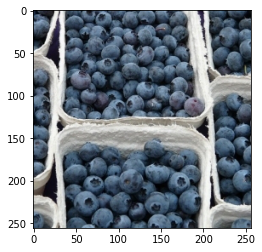

In [ ]:
image_for_inference = Image.open('/content/drive/MyDrive/Selise/dataset_256X256/test/berry/209_256.jpg')
# image_for_inference = image_for_inference.resize((32,32))
plt.imshow(image_for_inference)
image_for_inference = transform(image_for_inference)
model.eval()
output = model(image_for_inference.float().unsqueeze(0).to(params["device"], non_blocking=True))
predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
print(classified_class(output))